# Objective

* go through processing routine
* Do we have the relvant calibration files
    * What instruments are involved?
    * 1625 filterfunction for relevant instruments?

# Strategy

Convert to netcdf
* This should be hardcoded into the SURFRAD package
* copy the code from sail splash part


Apply Lab calibration
* Not sure if there is much sense in doing a lamp calibration. Below is another example of how that does not work --> Langley or transfer from other langely calibrated instrument.
* ~~There seems to be an error in the caluculation of the direct horizontal and normal in those products for splash (not shown in the publicated data).~~
* This part should actually be somewhat hard coded in a script somewhere in SURFRAD package!
* Set it up so it prcesses all new data that is comming in
* imitate what has been done in /home/grad/htelg/projects/ASR/splash/apply_calibrations/calibrate_v0.2.ipynb
* We will need MFRSR only
* use most recent Charls calibrations

Based on the files created above come up with a code to get AOD based on Lab cals
* choose single number for top fo the atmosphere spectral irradiance
* how is the earth-sun distance implemented now, deviation from mean?


# Convert to Netcdf

* make what is done for sail operational for SURFRAD
* merge into SURFRAD
* run for PMOD on cronjob

Make in separate notebook

# AOD

## langley calibration

### load calibration

In [1]:
import atmPy.radiation.retrievals.langley_calibration as atmlc

<xarray.Dataset> Size: 168B
Dimensions:     (wavelength: 6)
Coordinates:
  * wavelength  (wavelength) int32 24B 415 500 670 870 940 1625
Data variables:
    V0          (wavelength) float64 48B 7.879 7.236 6.648 7.507 7.635 6.218
    V0_std      (wavelength) float64 48B 0.01213 0.01096 ... 0.06541 0.01074
    V0_stderr   (wavelength) float64 48B 0.001672 0.001801 ... 0.003058 0.002362

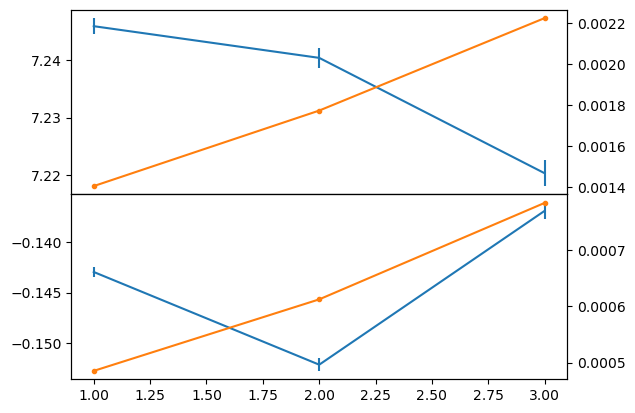

In [2]:
p2fld = pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.langleys/v0.1/')
lt = atmlc.open_langleys(p2fld)
lt.plot_ranked(wl = 500)
lt.V0_simple

### Load a file

## calibrate to irradiance

### what should the TOA irradiance be at that day, actually so the earth-sun distance is in full disply 

In [3]:
import atmPy.radiation.retrievals.spectral_irradiance as atmspec

In [4]:
fn = '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/frc_648_v0.1_20250928.nc'
fnmet = '/nfs/grad/campaign/frc/2025/MetaData.netcdf/frc-vi_metadata_20250928_preliminary.nc'
ds = xr.open_dataset(fn)

In [83]:
reload(atmspec)

<module 'atmPy.radiation.retrievals.spectral_irradiance' from '/home/hagen/prog/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py'>

In [84]:
gdd = atmspec.CombinedGlobalDiffuseDirect(ds.copy())
gdd.dataset['channel_wavelength'] = gdd.dataset.channel_wavelength.astype(float) #error in processing upstream, fix it in future versions!

In [85]:
gdd = gdd.apply_calibration_langley(lt)

/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/pysolar/solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warnings.warn \
/home/hagen/prog/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'channel = 500'}, xlabel='datetime', ylabel='direct_normal [W/m^2/nm]'>)

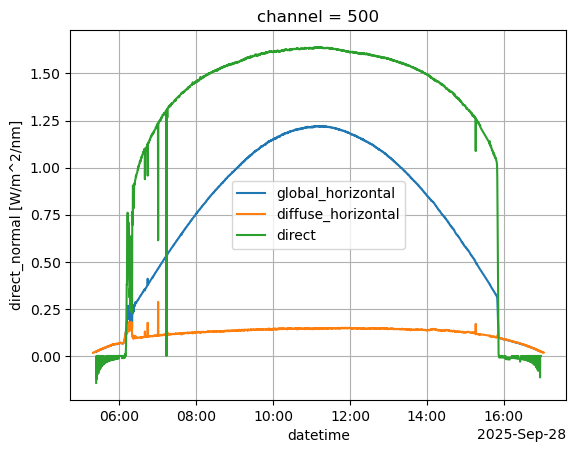

In [86]:
gdd.plot_overview()

In [87]:
self  = gdd.direct_normal_irradiation

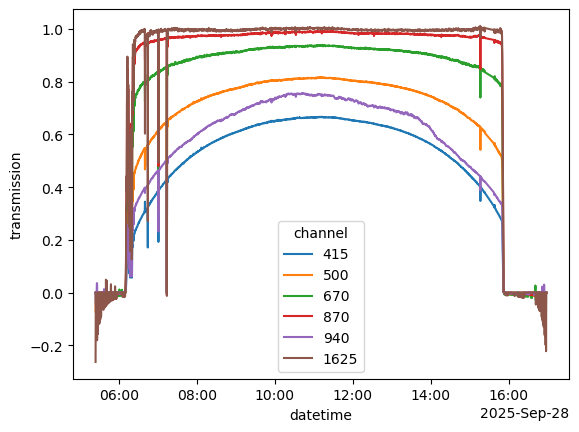

In [88]:
self.transmission.plot.line(x = 'datetime')

/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/pysolar/solartime.py:113: UserWarning: I don't know about leap seconds after 2023
  warnings.warn \
/home/hagen/prog/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()


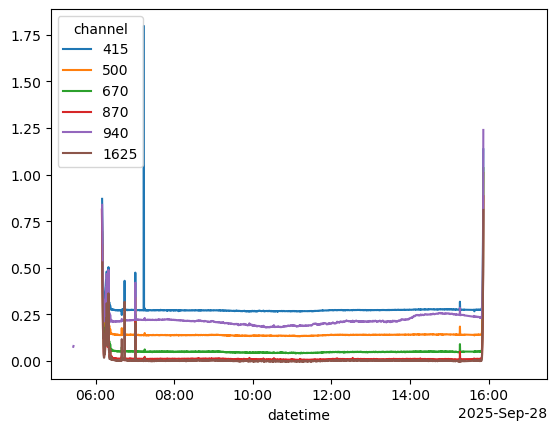

In [89]:
self.od_total.plot.line(x = 'datetime')

In [90]:
self.met_data = fnmet

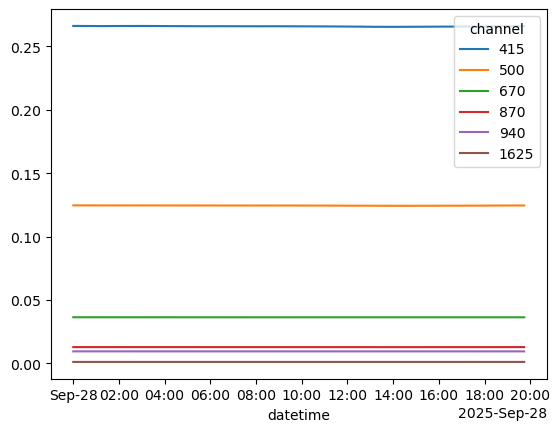

In [91]:
self.od_rayleigh.plot.line(x = 'datetime')

In [92]:
self.ozone_data = 300

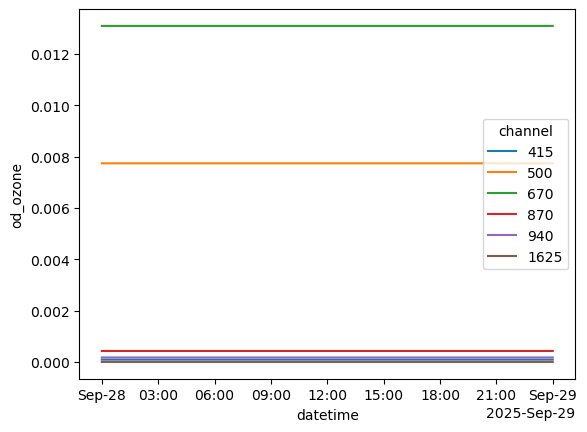

In [94]:
self.od_ozone.plot.line(x = 'datetime')

In [96]:
self.raw_data = self.raw_data.where(self.raw_data.channel < 1000, drop = True)

(-0.02, 0.03)

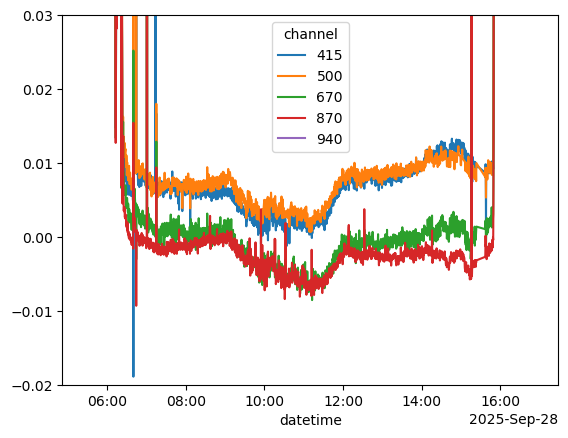

In [102]:
f,a = plt.subplots()
self.aod.plot.line(x = 'datetime', ax = a)
a.set_ylim(-0.02,0.03)

In [38]:
self.met_data

<xarray.Dataset> Size: 103kB
Dimensions:      (datetime: 4281)
Coordinates:
  * datetime     (datetime) datetime64[ns] 34kB 2025-09-28 ... 2025-09-28T23:...
Data variables:
    pressure     (datetime) float64 34kB 845.3 845.3 845.3 845.3 ... nan nan nan
    temperature  (datetime) float64 34kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    site_longitude:         -350.161743
    site_latitude:          46.807251
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    day_complete:           True
    parent_files:           /nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648/64...
    product_version:        0.1
    calibrated_spectral:    True
    clalibration_cosine:    True
    calibrated_langley:     True

In [60]:
self.raw_data['bla'] = ('datetime', 300 * np.ones(self.raw_data.datetime.shape))


In [61]:
self.raw_data

<xarray.Dataset> Size: 2MB
Dimensions:                   (datetime: 4281, channel: 5)
Coordinates:
  * datetime                  (datetime) datetime64[ns] 34kB 2025-09-28 ... 2...
  * channel                   (channel) int64 40B 415 500 670 870 940
Data variables: (12/14)
    alltime                   (datetime, channel) float64 171kB 0.0 1.0 ... 0.0
    global_horizontal         (datetime, channel) float64 171kB nan nan ... nan
    diffuse_horizontal        (datetime, channel) float64 171kB nan nan ... nan
    channel_wavelength        (channel) float64 40B 413.6 497.1 ... 868.8 937.8
    direct_horizontal         (datetime, channel) float64 171kB nan nan ... nan
    cosine_calibraion_direct  (datetime, channel) float64 171kB nan nan ... nan
    ...                        ...
    direct_normal             (datetime, channel) float64 171kB nan nan ... nan
    toa_spectral_irradiance   (channel, datetime) float64 171kB 1.746 ... 0.8545
    transmission              (datetime, channel) float64 171kB nan nan ... nan
    pressure                  (datetime, channel) float64 171kB 845.3 ... nan
    temperature               (datetime, channel) float64 171kB nan nan ... nan
    bla                       (datetime) float64 34kB 300.0 300.0 ... 300.0
Attributes: (12/18)
    site_longitude:         -350.161743
    site_latitude:          46.807251
    site_elevation:         0
    site:                   TMP
    site_name:              unknown
    calibrated_irradiance:  False
    ...                     ...
    day_complete:           True
    parent_files:           /nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648/64...
    product_version:        0.1
    calibrated_spectral:    True
    clalibration_cosine:    True
    calibrated_langley:     True

In [50]:
self.raw_data['bla'] = (300, 'datetime')

TypeError: Variable 'bla': Could not convert tuple of form (dims, data[, attrs, encoding]): (300, 'datetime') to Variable.

In [48]:
self.settings_ozone = 300

In [49]:
self.od_ozone

FileNotFoundError: [Errno 2] No such file or directory: '/home/grad/surfrad/aod/ozone/TMP_ozone.dat'

In [47]:
self.aod.plot.line(x = 'datetime')

/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hagen/programms/anaconda3/envs/py312/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


FileNotFoundError: [Errno 2] No such file or directory: '/home/grad/surfrad/aod/ozone/TMP_ozone.dat'

### what shoud V0 be at that day, as above

In [87]:
self = gdd

In [ ]:
def apply_Langley_calibration(self, calibrate_to = 'irradiance'):
    assert(calibration_to is in ['irradiance', 'transmission'])
    v0 = np.exp(lt.V0_simple.V0) / self.sun_position.sun_earth_distance.to_xarray()**2
    toasi = self.dataset.toa_spectral_irradiance / self.sun_position.sun_earth_distance.to_xarray()**2
    v0 = v0.rename({'wavelength':'channel'})
    
    dsnew = self.dataset.copy()
    gh = self.dataset.global_horizontal / v0 # ratio of irradiance of what we had at the top of the atmosphere at normal
    if calibrate_to == 'irradiance':
        gh = gh * toasi # actual irradiance observed
    dsnew['global_horizontal'] = gh
    
    dh = self.dataset.diffuse_horizontal / v0 
    dh = dh * toasi
    dsnew['diffuse_horizontal'] = dh
    
    dn = self.dataset.direct_normal / v0 
    dn = dn * toasi
    dsnew['direct_normal'] = dn
    return self.__clsass__(dsnew)
    

In [117]:
isinstance(lt, atmspec.atmlangcalib.Langley_Timeseries)

True

In [118]:
lt

In [94]:
v0 = np.exp(lt.V0_simple.V0) / self.sun_position.sun_earth_distance.to_xarray()**2

In [100]:
v0 = v0.rename({'wavelength':'channel'})


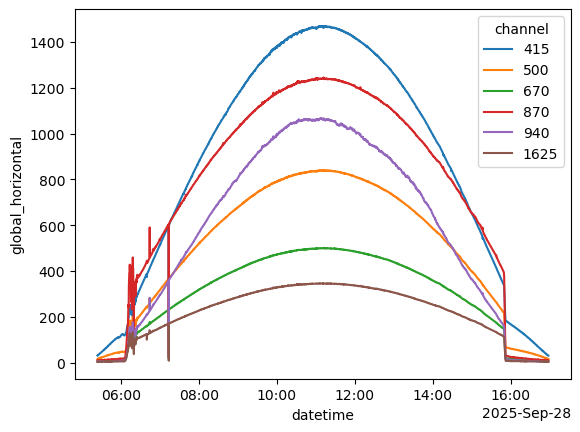

In [101]:
self.dataset.global_horizontal.plot.line(x = 'datetime')

In [104]:
self.dataset.global_horizontal.values

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], shape=(4281, 6))

In [115]:
dsnew = self.dataset.copy()
gh = self.dataset.global_horizontal / v0 
gh = gh * self.dataset.toa_spectral_irradiance
dsnew['global_horizontal'] = gh

dh = self.dataset.diffuse_horizontal / v0 
dh = dh * self.dataset.toa_spectral_irradiance
dsnew['diffuse_horizontal'] = dh

dn = self.dataset.direct_normal / v0 
dn = dn * self.dataset.toa_spectral_irradiance
dsnew['direct_normal'] = dn

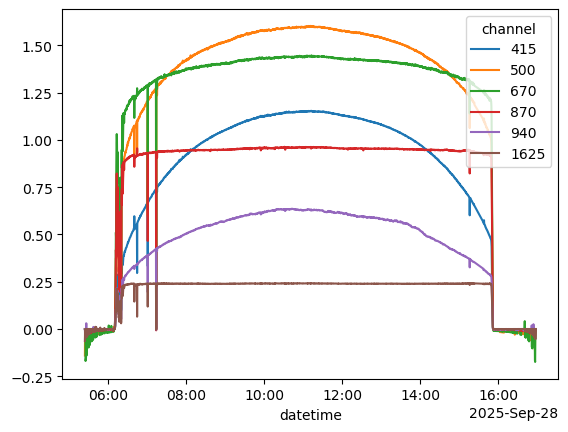

In [114]:
dn.plot.line(x = 'datetime')

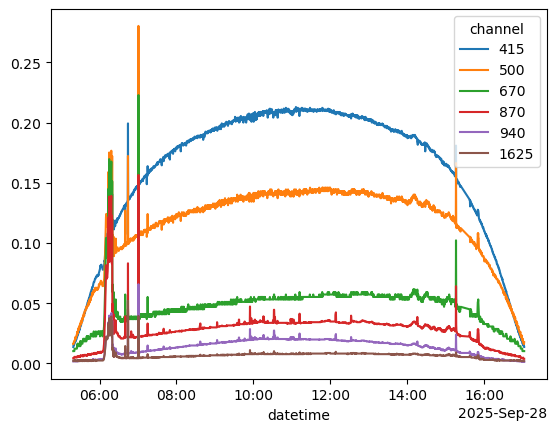

In [113]:
dh.plot.line(x = 'datetime')

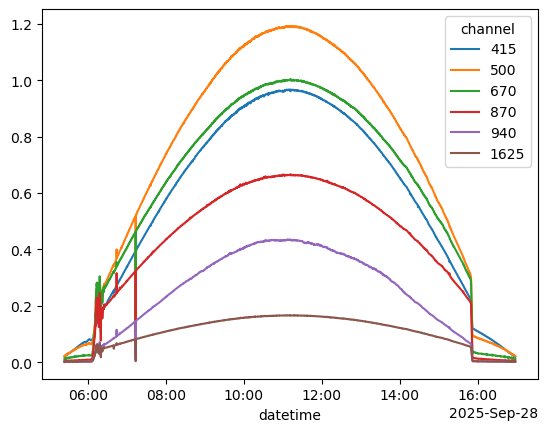

In [110]:
gh.plot.line(x = 'datetime')

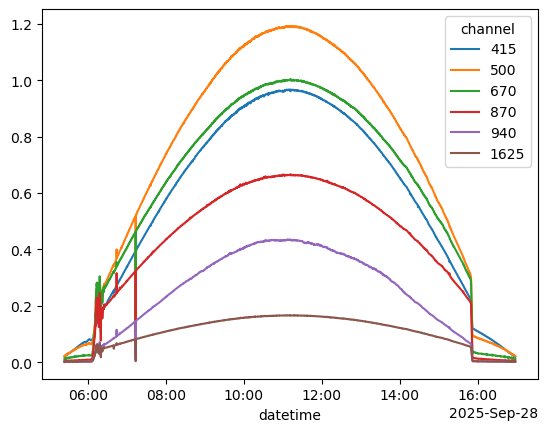

In [110]:
gh.plot.line(x = 'datetime')

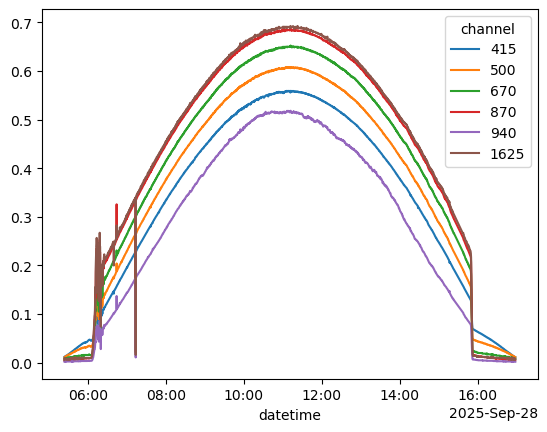

In [106]:
gh.plot.line(x = 'datetime')

In [92]:
np.exp(v0)

<xarray.DataArray (wavelength: 6, datetime: 4281)> Size: 205kB
array([[2554.08573885, 2554.08840061, 2554.09106238, ..., 2565.70344429,
        2565.70612994, 2565.7088156 ],
       [1345.79050805, 1345.79179604, 1345.79308403, ..., 1351.4111005 ,
        1351.41239956, 1351.41369863],
       [ 750.01362197,  750.01428152,  750.01494108, ...,  752.89132622,
         752.89199122,  752.89265622],
       [1763.01869819, 1763.02044873, 1763.02219927, ..., 1770.65839199,
        1770.66015786, 1770.66192373],
       [2002.37487565, 2002.37689771, 2002.37891977, ..., 2011.19987755,
        2011.20191747, 2011.2039574 ],
       [ 488.83617266,  488.83657473,  488.83697682, ...,  490.590277  ,
         490.5906823 ,  490.5910876 ]], shape=(6, 4281))
Coordinates:
  * wavelength  (wavelength) int32 24B 415 500 670 870 940 1625
  * datetime    (datetime) datetime64[ns] 34kB 2025-09-28 ... 2025-09-28T23:5...

### convert VO to irradiance
### add the TOA info in the file for later use when AOD is calculated

## try by using lamp calibrations (fail)

In [5]:
fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/cbc_specflux_20230528.nc'
dssf = xr.open_dataset(fn)
fn = '/nfs/grad/campaigns/splash/data_products/spectral_surface_albedo/v1.0/cbc/cbc.spectral_surface_albedo.20230528.nc'
dsal = xr.open_dataset(fn)

In [6]:
atmspec.CombinedGlobalDiffuseDirect

atmPy.radiation.retrievals.spectral_irradiance.CombinedGlobalDiffuseDirect

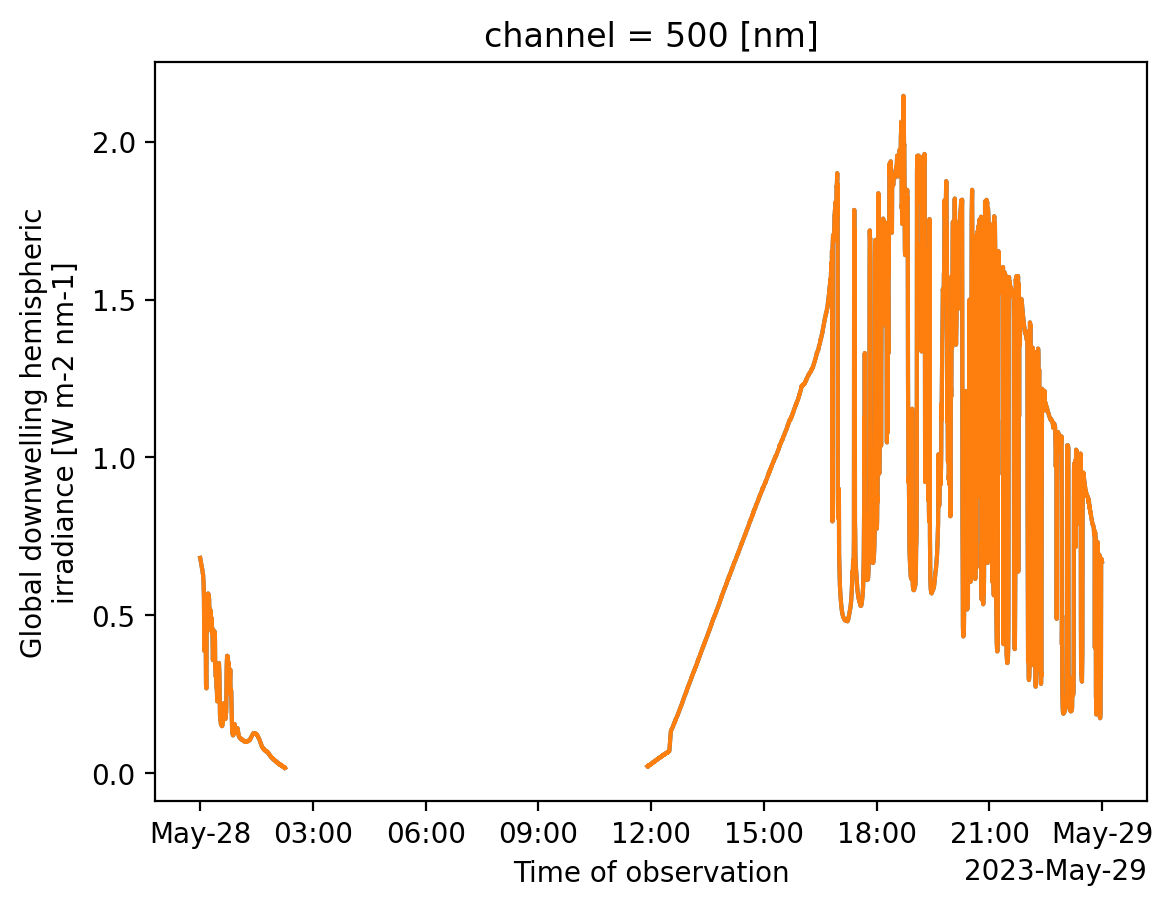

In [7]:
dssf.global_horizontal.sel(channel=550, method='nearest').plot()
dsal.downwelling_hemispheric_irradiance.sel(channel=550, method='nearest').plot()

## Use the top of the atmosphere solar constant

Once you correct for the variation in the Earth–Sun distance (which causes the ~±3.5% annual cycle in irradiance), the solar irradiance at the top of the atmosphere (the “solar constant”) is essentially constant:  

- **Mean value**: ~1361 W m⁻² (according to TIM/SORCE and other modern radiometers).  
- **Short-term variability**:  
  - On the timescale of minutes to hours: very small (≲0.01%), except during solar flares.  
  - Over the 11-year solar cycle: about ±0.05% to ±0.1% (~1–1.5 W m⁻²).  
- **Longer term trends**: No statistically significant secular trend has been measured over the past 40+ years of satellite monitoring; variations remain within ~1 W m⁻².  

👉 So, once Earth–Sun distance is accounted for, **the top-of-atmosphere solar irradiance is stable to better than 0.1%**, with only the solar cycle and transient events (like flares) causing small changes.  

Do you want me to also show how this translates into changes in absorbed solar energy by Earth (W m⁻² at the surface averaged globally)?


In [1]:
def read_splash_met_data(site):    
    year = pd.to_datetime(ro.dataset.datetime.values[0]).year
    p2f_met = f'/home/grad/sedlar/data/splash/surfrad/all_variables/{site}_concat_surfrad_all_variables{year}.nc'
    dsmet = xr.open_dataset(p2f_met)
    dsmet['time'] = pd.to_datetime(dsmet['time'], unit='d')
    pt_interp = dsmet[['temp','pressure']].interp(time = ro.dataset.datetime)
    return pt_interp


In [2]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad as atmsrf
import atmPy.radiation.retrievals.spectral_irradiance as atmspec

In [3]:

fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/cbc_specflux_20220625.nc'
# fn = '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.sbs2021/v0.2/cbc_specflux_20230528.nc'
dssf = xr.open_dataset(fn)
dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/cbc_specflux_20220625.nc'

In [521]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/ckp/cal.fact/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

In [522]:
i = 224 # 102: claer sky
# i += 1
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.3
dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
i

ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'

ro.direct_normal_irradiation.transmission
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('ckp')
# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
a.set_ylim(-0.1,0.4)

IndexError: list index out of range

## lets see if by scaling the sunspectrum a bit we can get better results

In [ ]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

In [177]:
reload(atmspec)
reload(atmsrf)

<module 'atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad' from '/home/grad/htelg/prog_dev/atm-py/atmPy/data_archives/NOAA_ESRL_GMD_GRAD/surfrad/surfrad.py'>

258


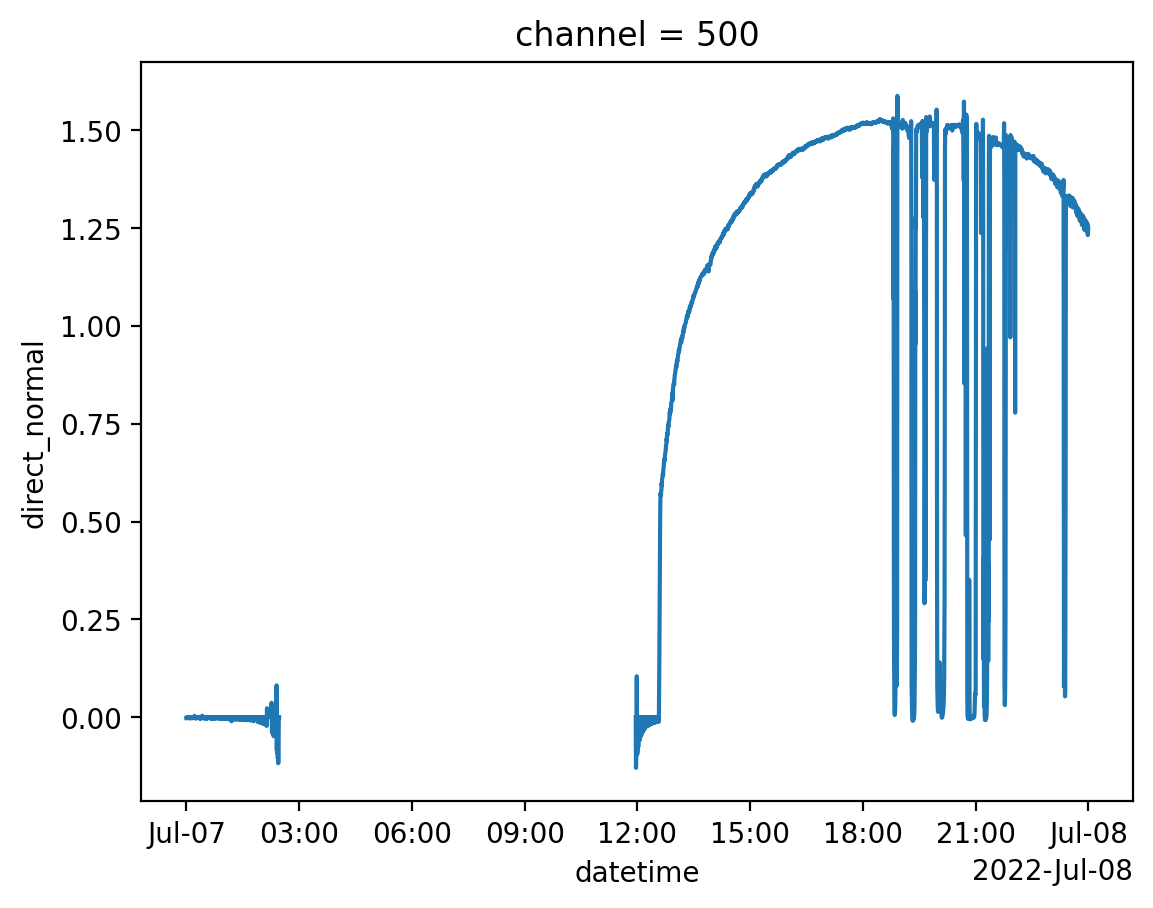

In [178]:
i = 258 # 102: claer sky, but winter
          # 242: clear sky, but summer
          # 258: clear most of the day, but some clouds in the afternoon

# i += 1 #
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.1
# dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
print(i)
rod = ro.direct_normal_irradiation
rod.dataset.direct_normal.sel(channel = 500).plot(x='datetime')

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()


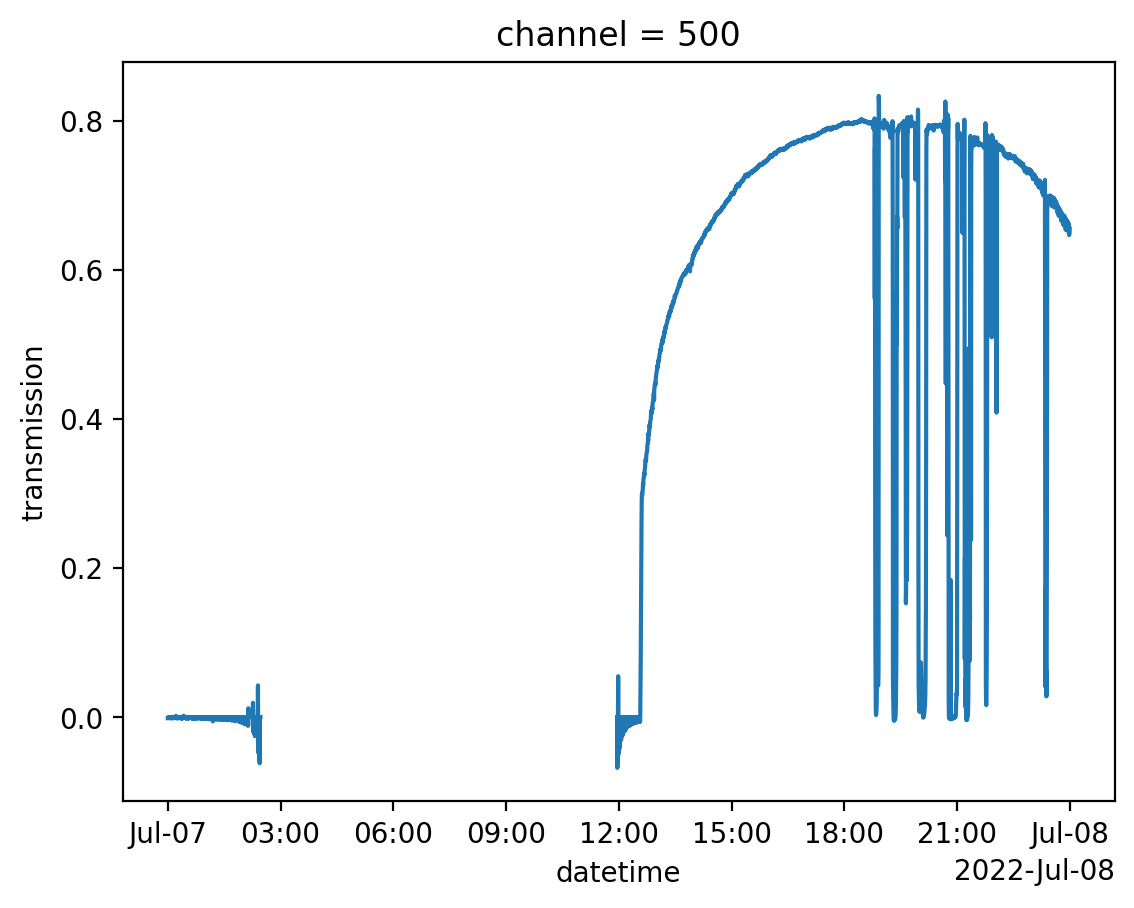

In [179]:
rod.settings_calibration = 'toa_radiation'
rod.transmission.sel(channel = 500).plot()

In [189]:
rod._solarspectrum = None
rod.solarspectrum
None

/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(0.0, 0.5)

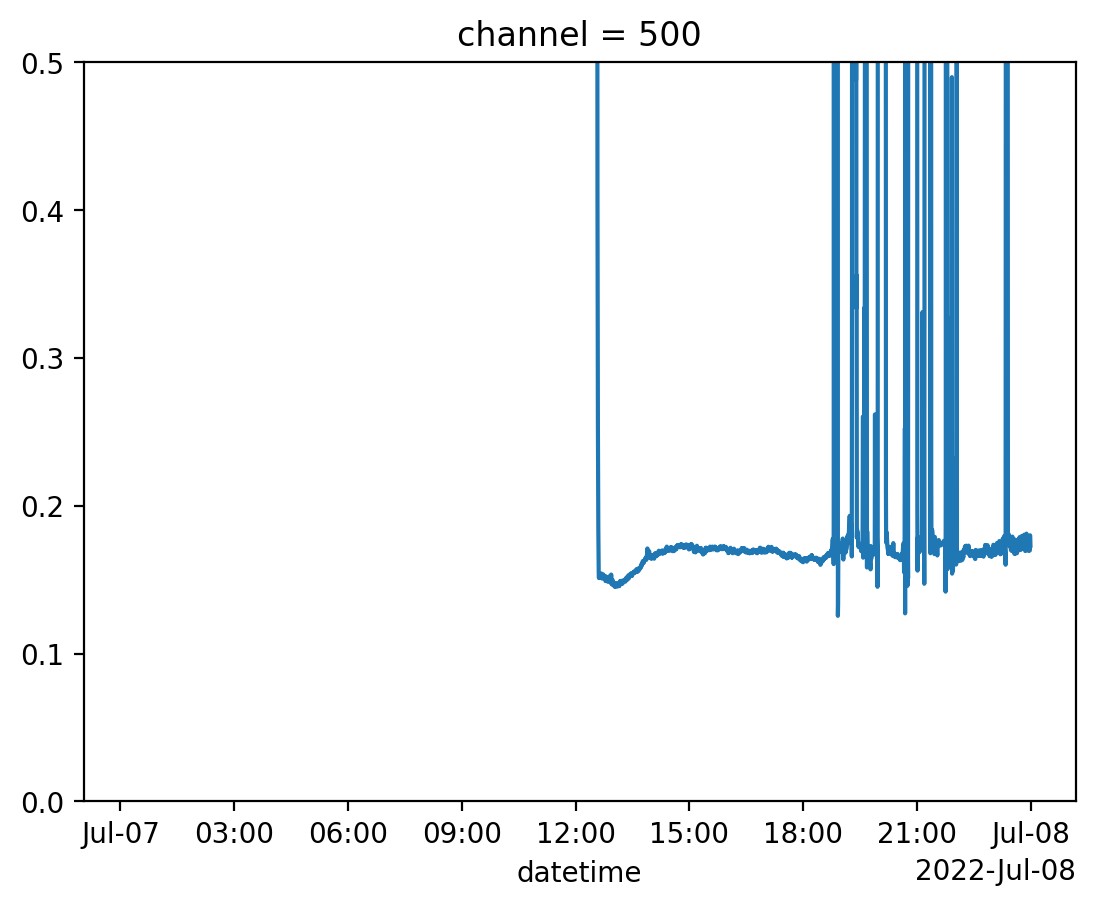

In [190]:
rod.settings_calibration = 'toa_radiation'
rod._transmission = None
rod._solarspectrum *=  0.95
# rod.transmission.sel(channel = 500).plot()
rod.od_total.sel(channel = 500).plot()
a = plt.gca()
a.set_ylim(0,0.5)

In [191]:
ro.direct_normal_irradiation.settings_ozone = 300 # DU
rod.settings_metdata = lambda : read_splash_met_data('cbc')

/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(0.035, 0.1)

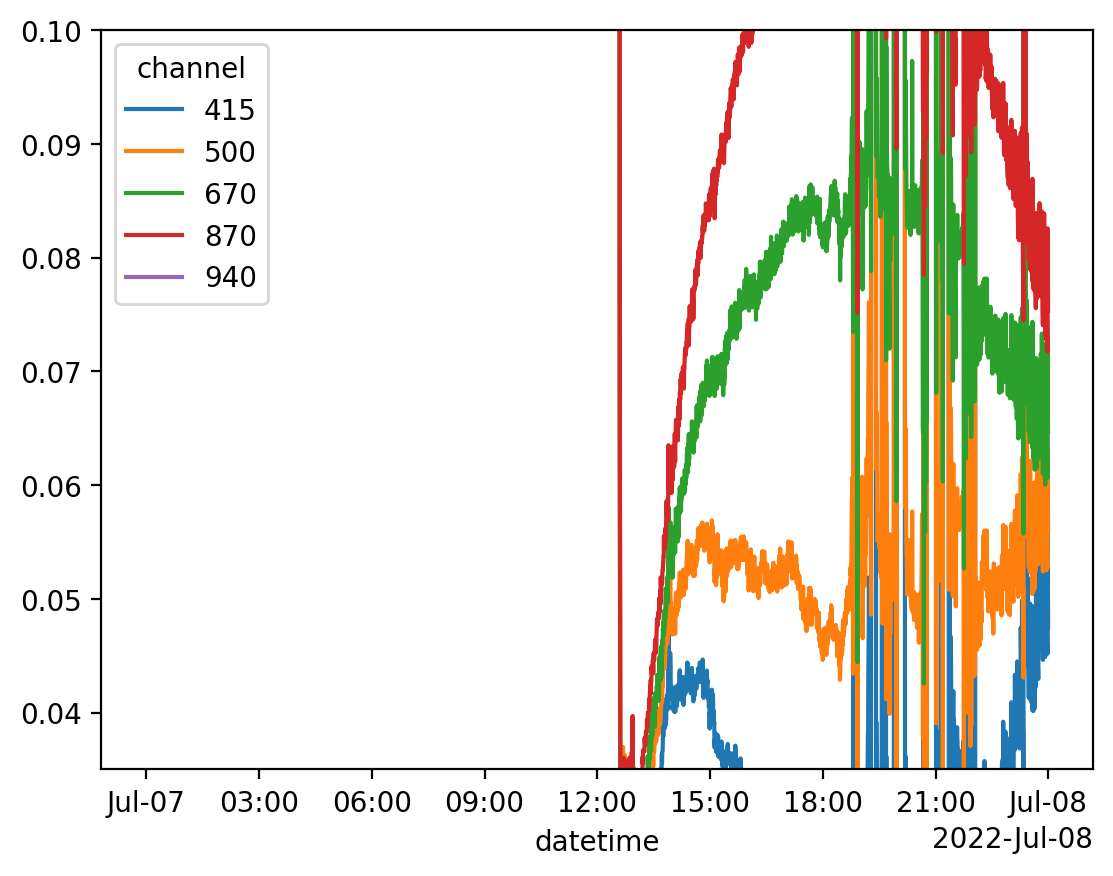

In [192]:
rod._aod = None
rod.aod.plot.line(x = 'datetime')
a = plt.gca()
a.set_ylim(0.035,0.06)
a.set_ylim(0.035,0.1)

In [103]:
rod.solarspectrum*100000

<xarray.Dataset> Size: 27kB
Dimensions:     (wavelength: 1697)
Coordinates:
  * wavelength  (wavelength) float64 14kB 119.5 120.5 121.5 ... 4e+05 1e+06
Data variables:
    irradiance  (wavelength) float64 14kB 18.49 167.7 ... 3.017e-05 1.01e-06

/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(0.0, 0.5)

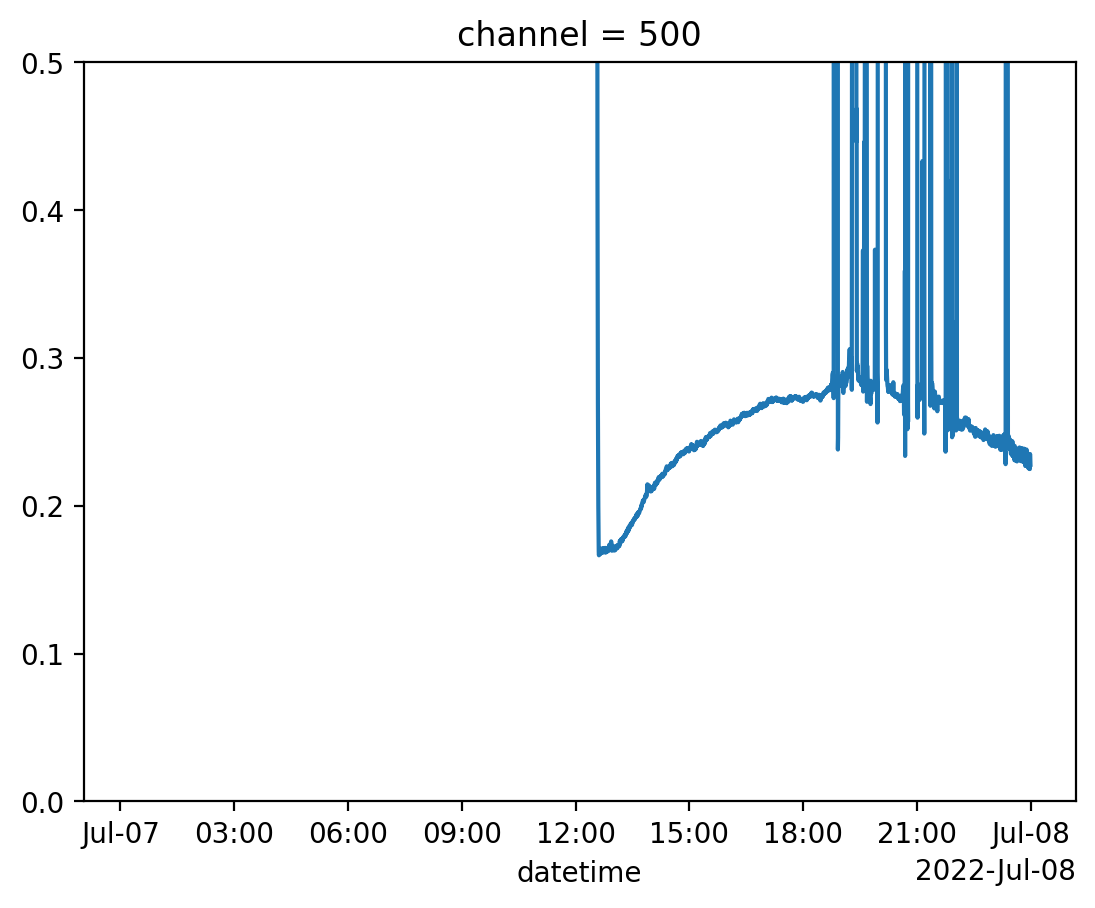

In [104]:
rod._solarspectrum *=  20
rod._transmission = None
rod.settings_calibration = 'toa_radiation'
# self._solarspctrum = None
f,a = plt.subplots()
rod.od_total.sel(channel = 500).plot(ax = a)
a.set_ylim(0,0.5)

/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(0.0, 0.5)

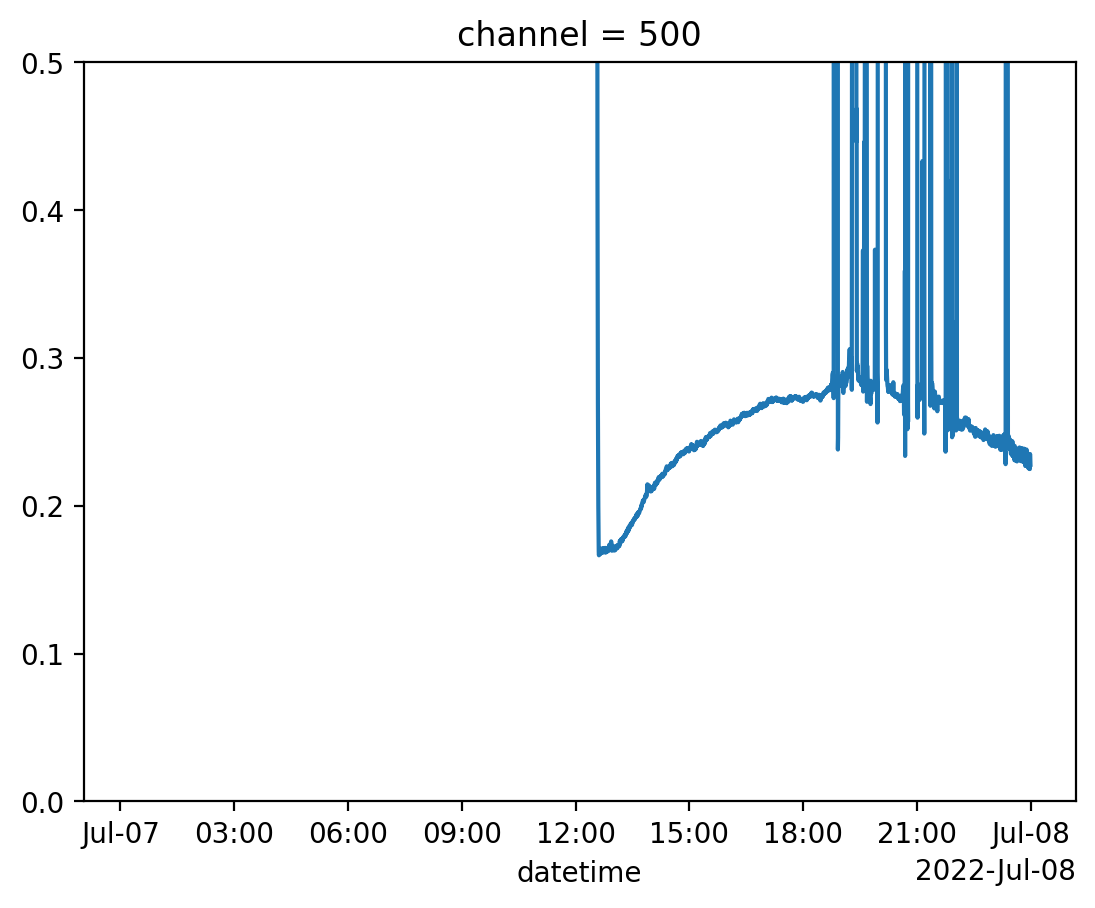

In [101]:
rod._solarspectrum *=  1.1
rod._transmission = None
rod.settings_calibration = 'toa_radiation'
# self._solarspctrum = None
f,a = plt.subplots()
rod.od_total.sel(channel = 500).plot(ax = a)
a.set_ylim(0,0.5)

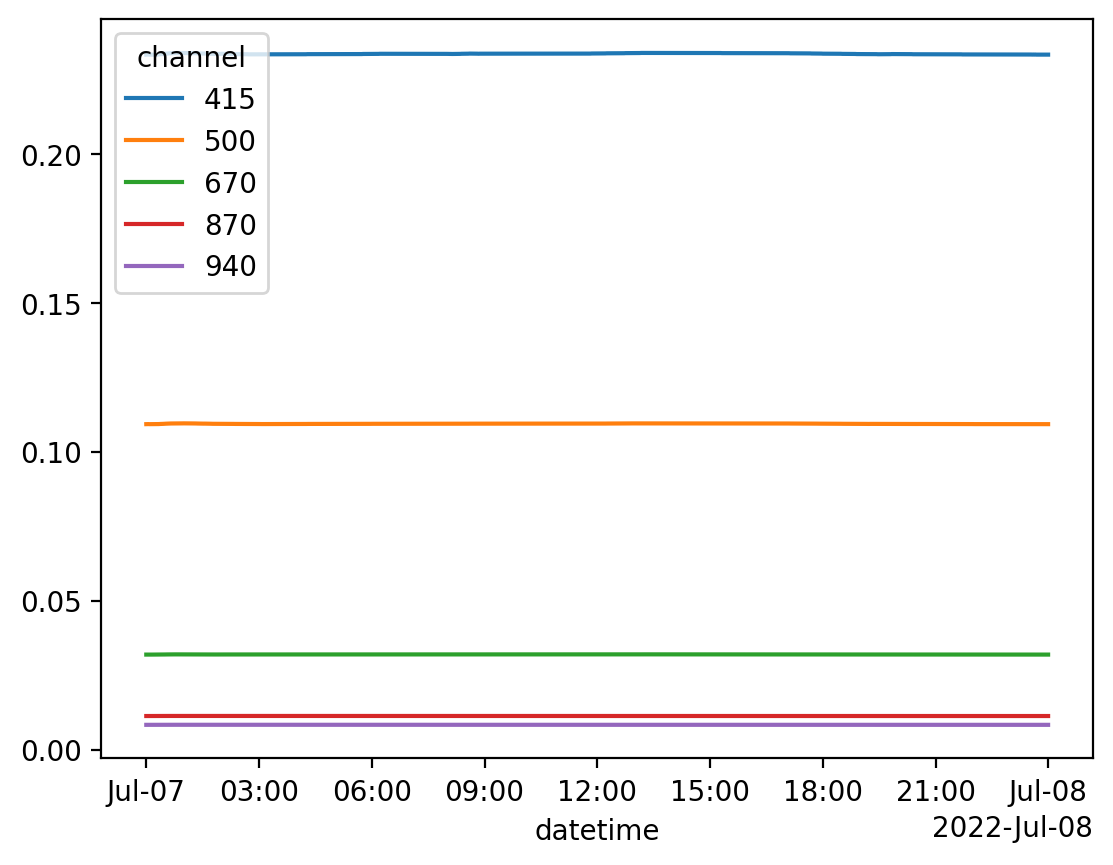

In [ ]:
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('cbc')

ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime',)

In [ ]:
ro.direct_normal_irradiation.sun_position

,elevation,azimuth,airmass,sun_earth_distance,ampm
datetime,,,,,
2022-07-07 00:00:00.000000000,0.484009,4.847332,2.149005,1.016696,b'pm'
2022-07-07 00:00:19.871999809,0.482895,4.848158,2.153569,1.016696,b'pm'
2022-07-07 00:00:39.744000250,0.481782,4.848985,2.158155,1.016696,b'pm'
2022-07-07 00:00:59.616000069,0.480668,4.849810,2.162762,1.016696,b'pm'
2022-07-07 00:01:20.352000172,0.479506,4.850672,2.167593,1.016696,b'pm'
...,...,...,...,...,...
2022-07-07 23:58:19.776000017,0.489124,4.840961,2.128326,1.016680,b'pm'
2022-07-07 23:58:39.647999827,0.488009,4.841790,2.132794,1.016680,b'pm'
2022-07-07 23:59:00.383999930,0.486846,4.842655,2.137479,1.016680,b'pm'


/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(0.0, 0.5)

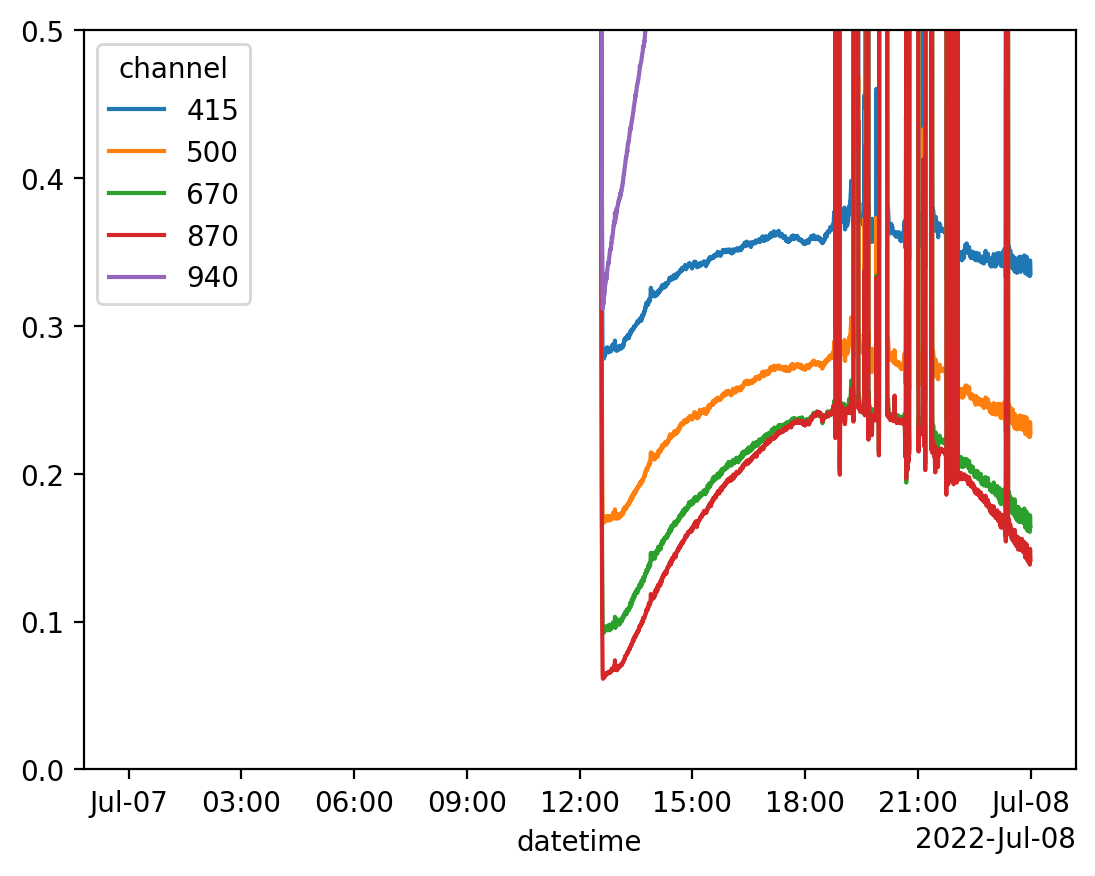

In [ ]:
f,a = plt.subplots()
ro.direct_normal_irradiation.od_total.plot.line(x='datetime',ax= a)
a.set_ylim(0,0.5)

(0.0, 0.4)

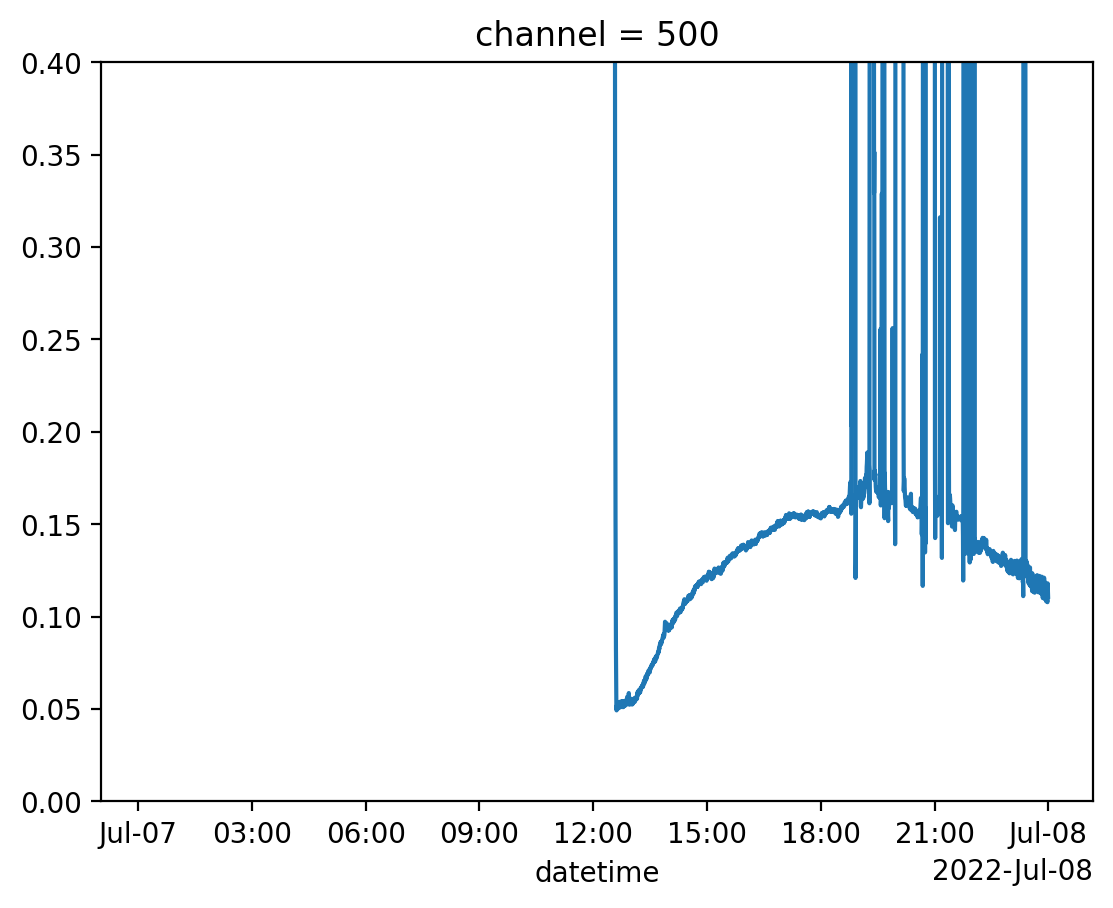

In [ ]:

# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
# ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
ro.direct_normal_irradiation.aod.sel(channel = 500).plot(ax=a)
a.set_ylim(0,0.4)

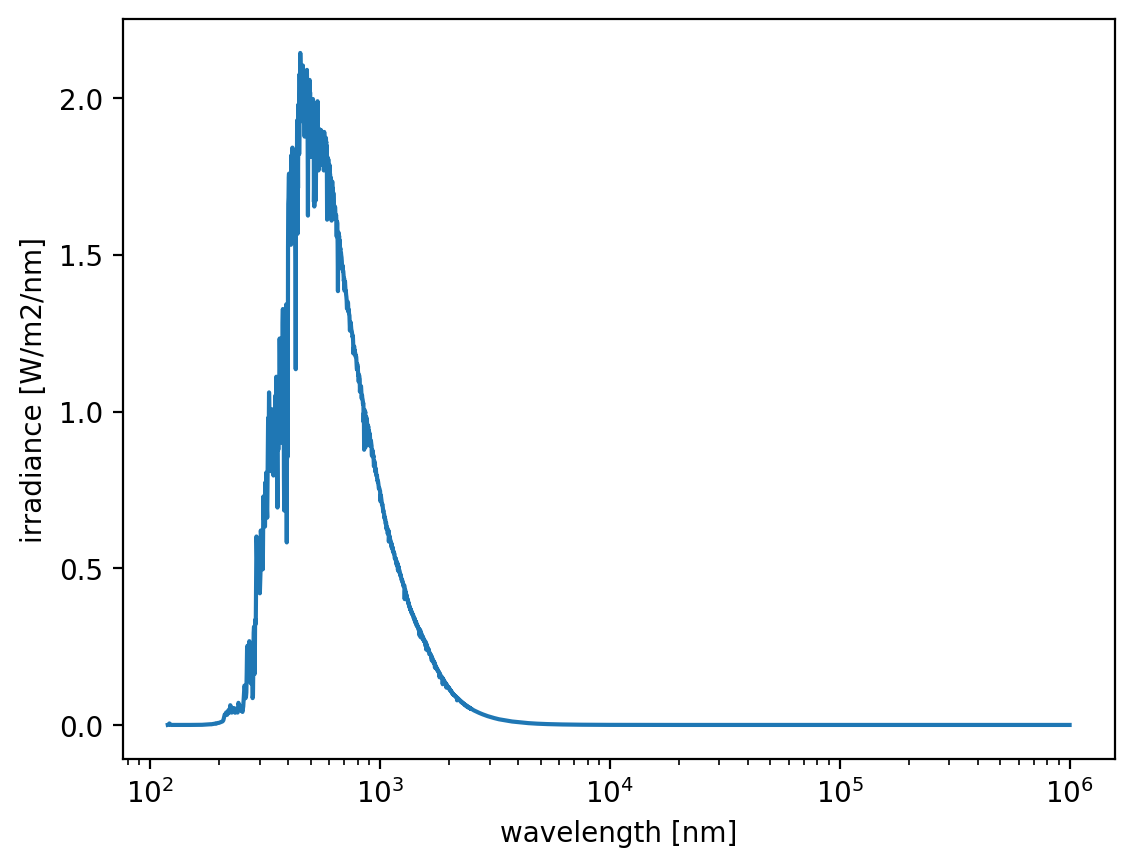

In [ ]:
f,a = plt.subplots()
ro.direct_normal_irradiation.solarspectrum.irradiance.plot(ax = a)
a.set_xscale('log')

In [ ]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.fact/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py:1116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['co2'] = xr.DataArray(np.zeros(tuple(self.raw_data.dims[d] for d in ['datetime', 'channel'])),


(0.0, 0.4)

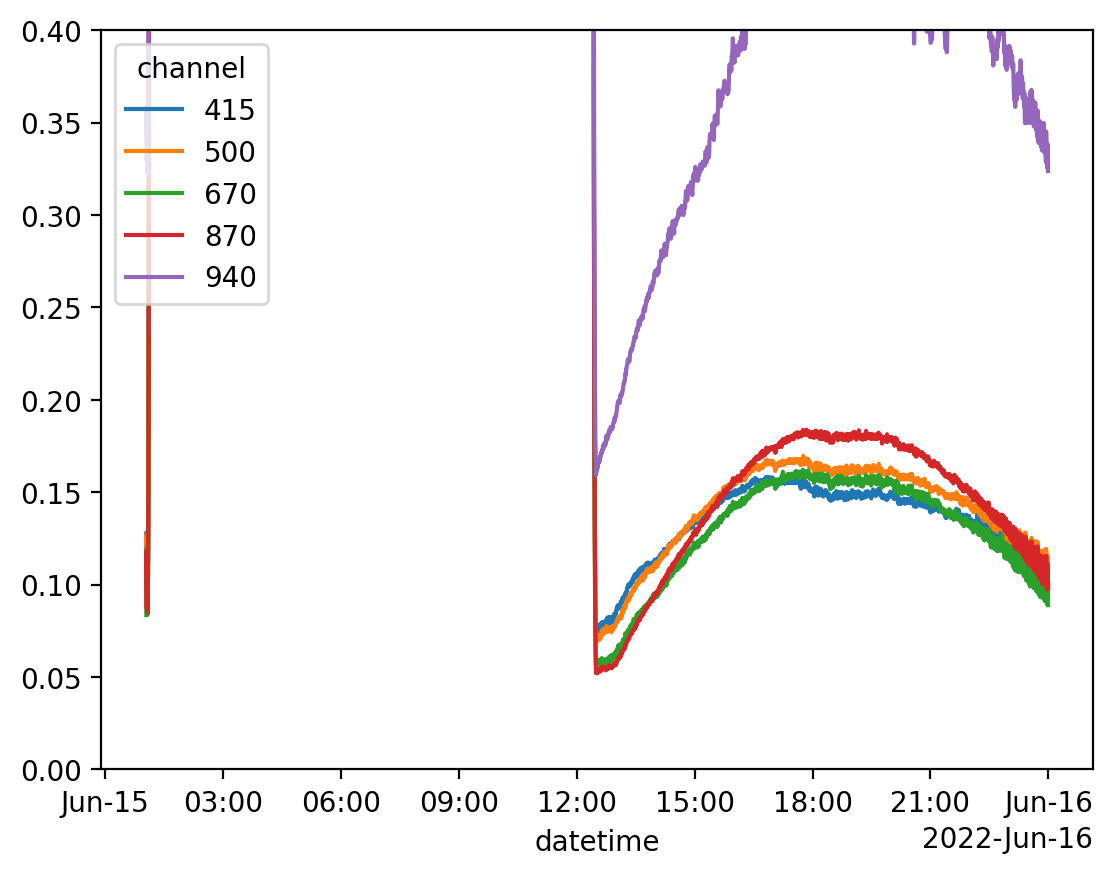

In [ ]:
i = 242 # 102: claer sky, but winter
          # 242: clear sky, but summer
# i += 1 #
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.1
# dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
i


ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'

ro.direct_normal_irradiation.transmission
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('cbc')
# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
a.set_ylim(0,0.4)

In [ ]:
ro.diffuse_horizontal_irradiation.tp

AttributeError: 'DiffuseHorizontalIrradiation' object has no attribute 'tp'

## This does not look that good, but why?

In [57]:
reload(atmspec)
reload(atmsrf)

<module 'atmPy.data_archives.NOAA_ESRL_GMD_GRAD.surfrad.surfrad' from '/home/grad/htelg/prog_dev/atm-py/atmPy/data_archives/NOAA_ESRL_GMD_GRAD/surfrad/surfrad.py'>

In [58]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.2021/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

258


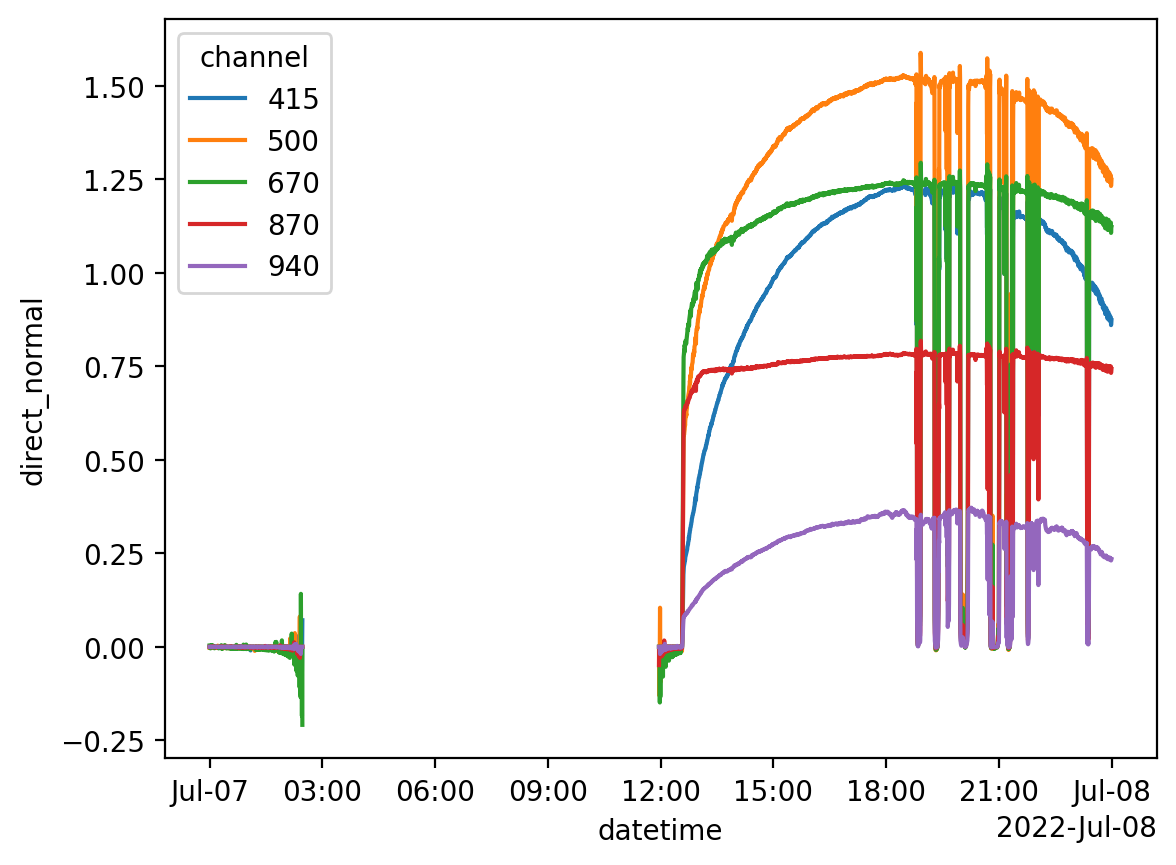

In [ ]:
# i = 242 # 102: claer sky, but winter
          # 242: clear sky, but summer
          # 258: clear most of the day, but some clouds in the afternoon

i += 1 #
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.1
# dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
print(i)
ro.direct_normal_irradiation.dataset.direct_normal.plot.line(x='datetime')

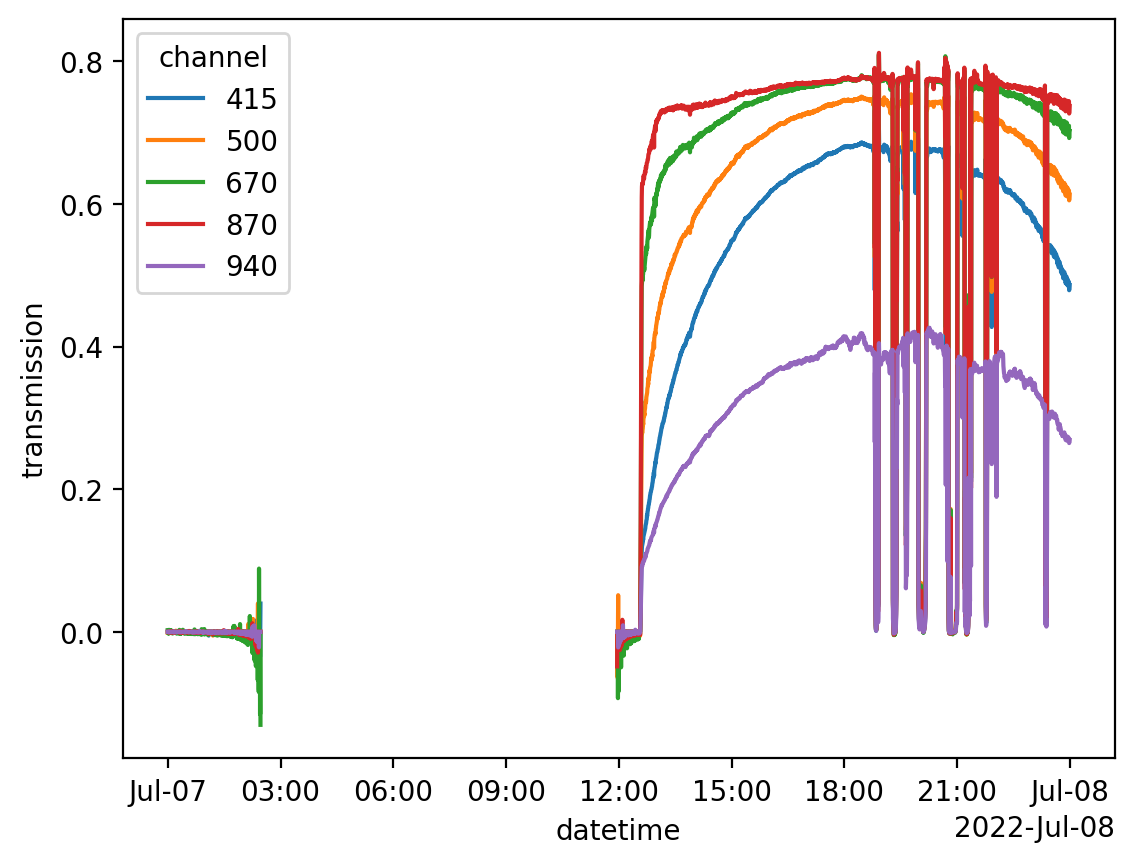

In [73]:
ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'
ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')

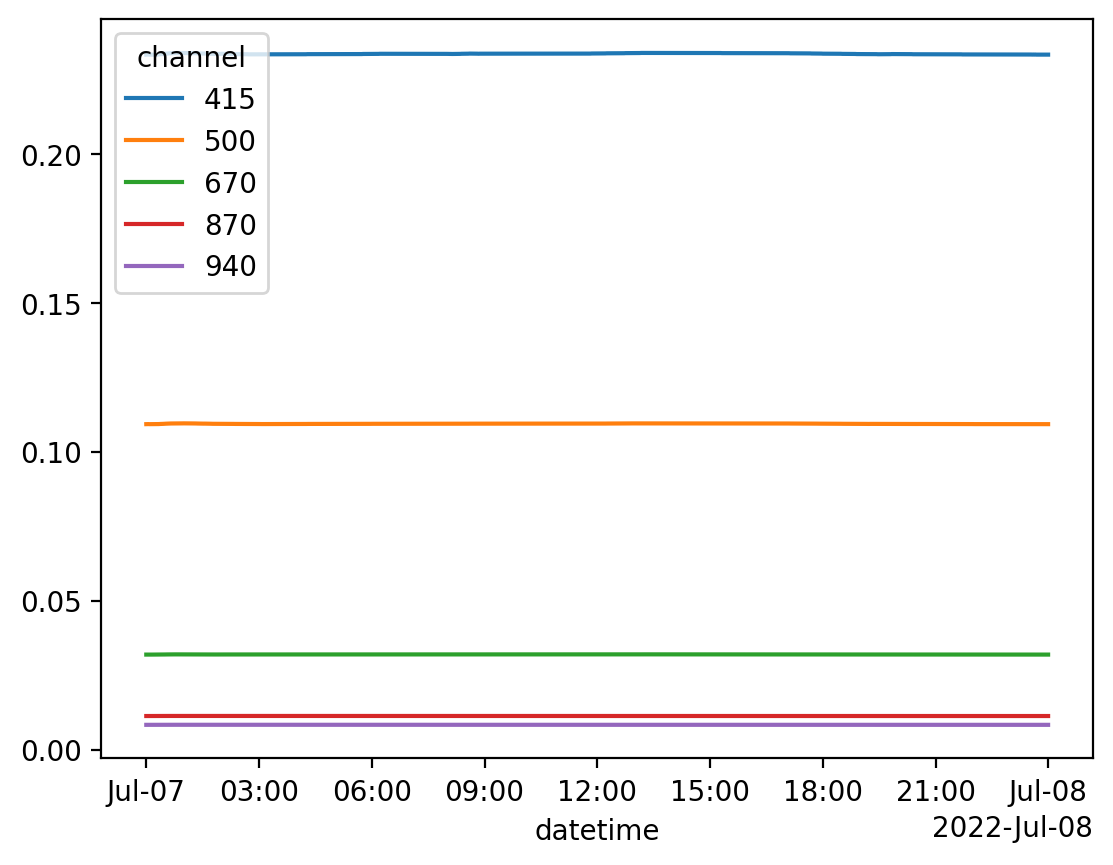

In [74]:
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('cbc')

ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime',)

In [75]:
ro.direct_normal_irradiation.sun_position

,elevation,azimuth,airmass,sun_earth_distance,ampm
datetime,,,,,
2022-07-07 00:00:00.000000000,0.484009,4.847332,2.149005,1.016696,b'pm'
2022-07-07 00:00:19.871999809,0.482895,4.848158,2.153569,1.016696,b'pm'
2022-07-07 00:00:39.744000250,0.481782,4.848985,2.158155,1.016696,b'pm'
2022-07-07 00:00:59.616000069,0.480668,4.849810,2.162762,1.016696,b'pm'
2022-07-07 00:01:20.352000172,0.479506,4.850672,2.167593,1.016696,b'pm'
...,...,...,...,...,...
2022-07-07 23:58:19.776000017,0.489124,4.840961,2.128326,1.016680,b'pm'
2022-07-07 23:58:39.647999827,0.488009,4.841790,2.132794,1.016680,b'pm'
2022-07-07 23:59:00.383999930,0.486846,4.842655,2.137479,1.016680,b'pm'


/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(0.0, 0.5)

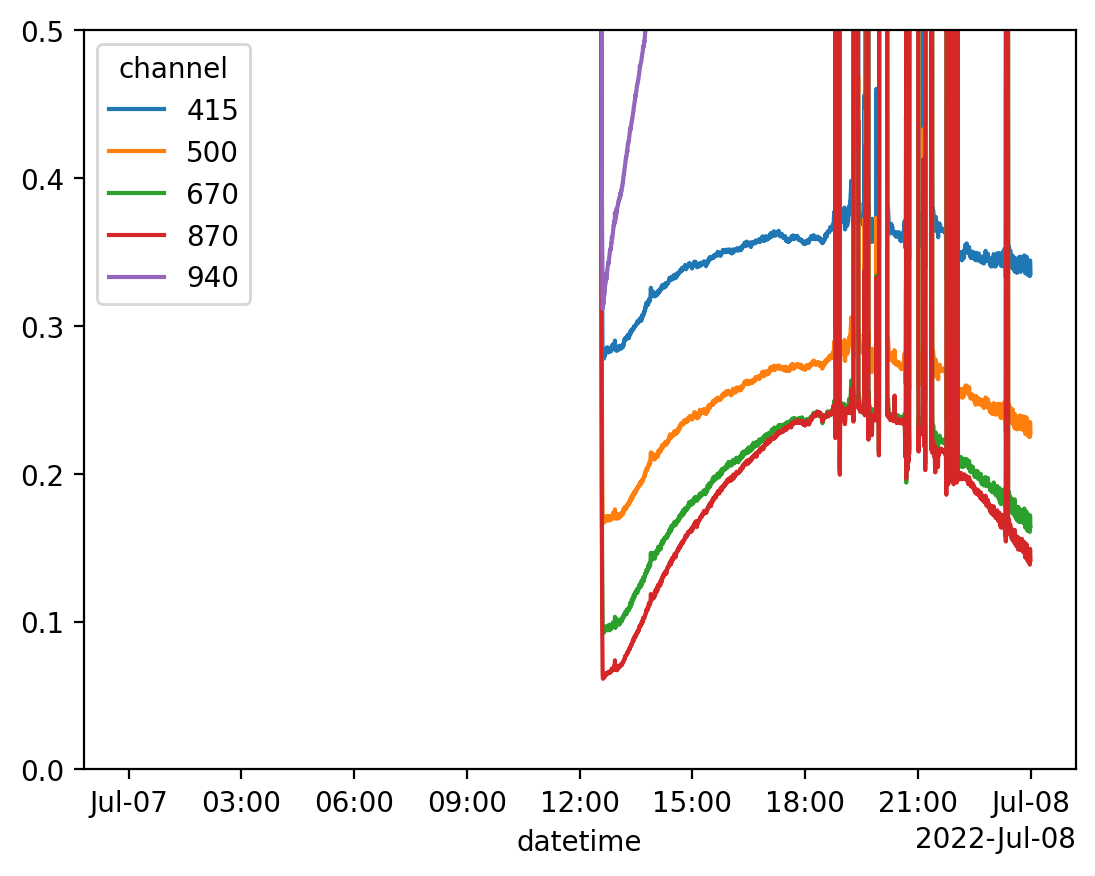

In [76]:
f,a = plt.subplots()
ro.direct_normal_irradiation.od_total.plot.line(x='datetime',ax= a)
a.set_ylim(0,0.5)

(0.0, 0.4)

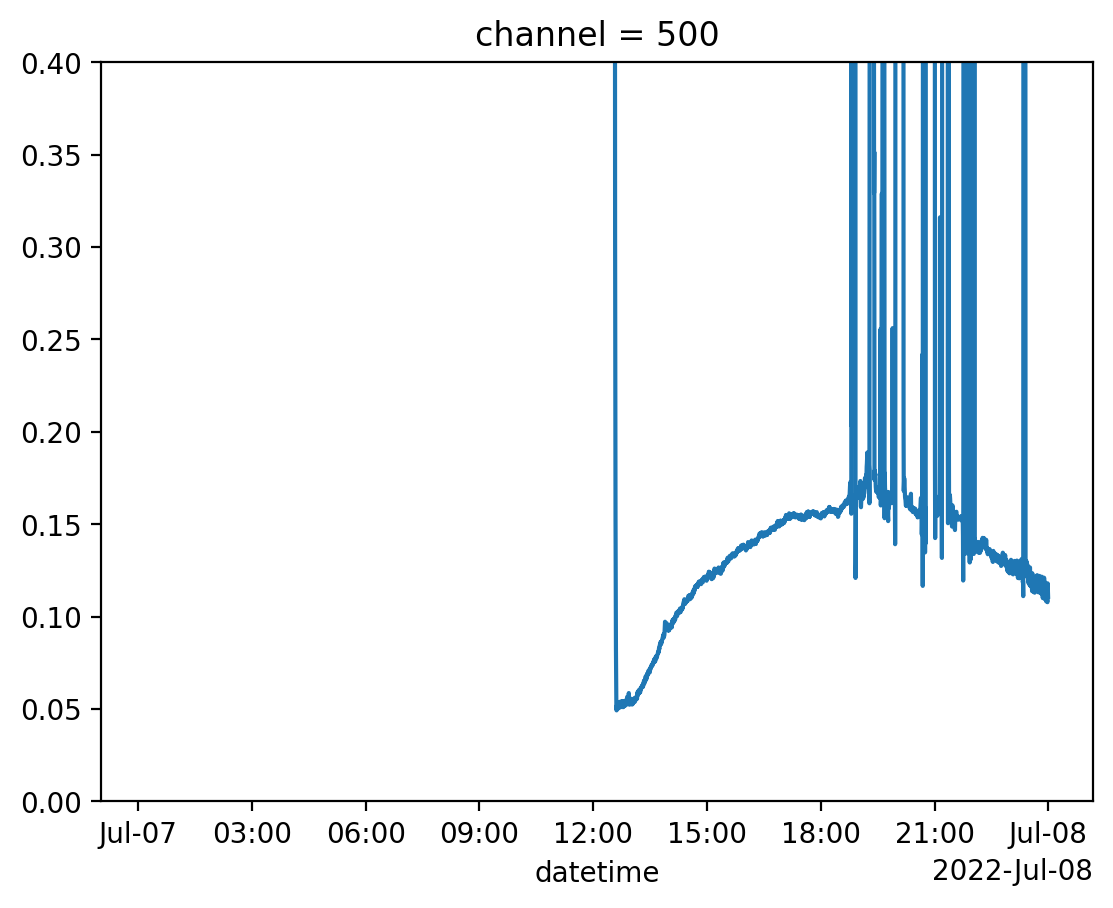

In [77]:

# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
# ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
ro.direct_normal_irradiation.aod.sel(channel = 500).plot(ax=a)
a.set_ylim(0,0.4)

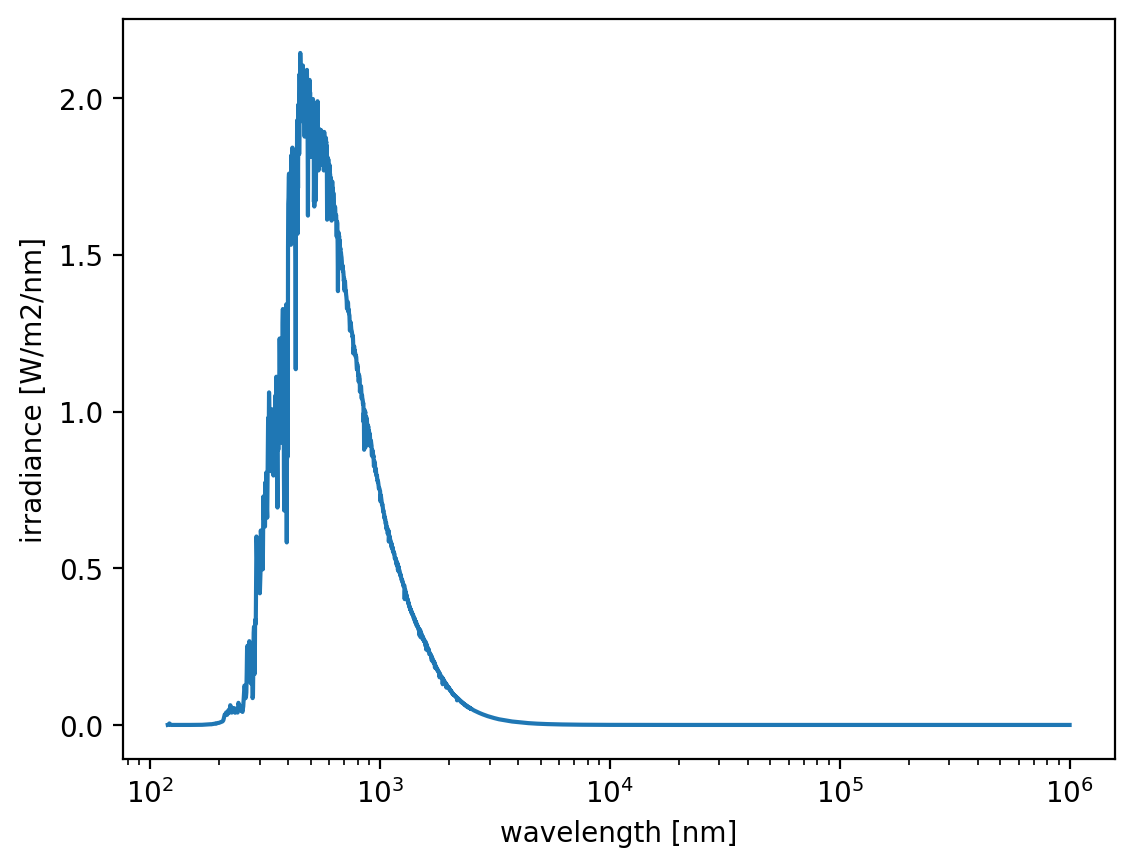

In [18]:
f,a = plt.subplots()
ro.direct_normal_irradiation.solarspectrum.irradiance.plot(ax = a)
a.set_xscale('log')

In [ ]:
fld = pl.Path('/nfs/grad/campaigns/splash/data_products/spectral_irradiances_downwelling/cbc/cal.fact/v0.2/')
fns = list(fld.glob('*'))
fns.sort()

/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/solar.py:125: UserWarning: Discarding nonzero nanoseconds in conversion.
  date = date.to_pydatetime()
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/export2/htelg/programs/miniconda3/envs/py12t2/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/grad/htelg/prog_dev/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py:1116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['co2'] = xr.DataArray(np.zeros(tuple(self.raw_data.dims[d] for d in ['datetime', 'channel'])),


(0.0, 0.4)

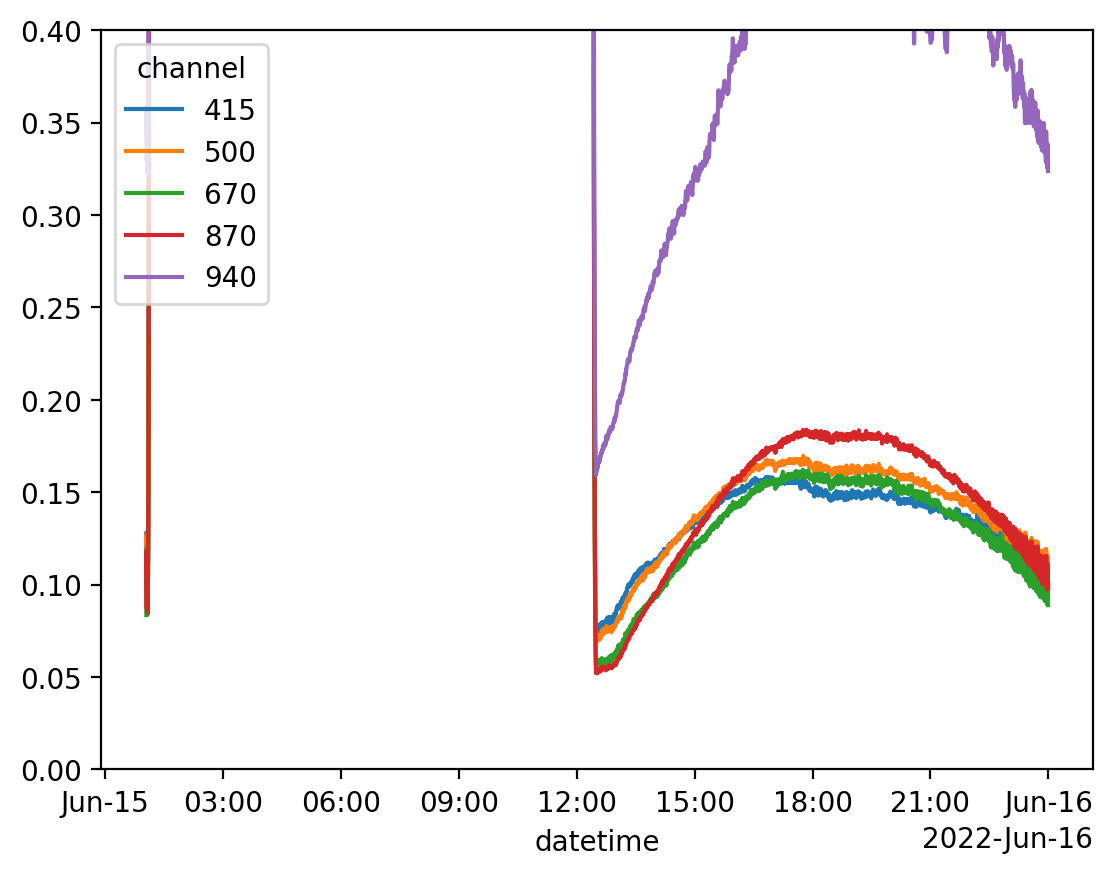

In [ ]:
i = 242 # 102: claer sky, but winter
          # 242: clear sky, but summer
# i += 1 #
fn = fns[i]
dssf = xr.open_dataset(fn)
scale = 1 + 0.1
# dssf['direct_normal'] *= scale
dssf = dssf.drop_sel(channel= 1625) # for now as it is more complicated
# dssf = dssf.rename({'channel_wavelength': 'channel_center'})
ro = atmspec.CombinedGlobalDiffuseDirect(dssf)
# ro.plot_overview(show_alltime=False)
i


ro.direct_normal_irradiation.settings_calibration = 'toa_radiation'

ro.direct_normal_irradiation.transmission
# ro.direct_normal_irradiation._transmission *= scale

# ro.direct_normal_irradiation.transmission.plot.line(x = 'datetime')
# f,a = plt.subplots()
# ro.direct_normal_irradiation.od_total.plot.line(x='datetime', ax=a)
# a.set_ylim(0,1)

ro.direct_normal_irradiation.settings_metdata = lambda : read_splash_met_data('cbc')
# ro.direct_normal_irradiation.od_rayleigh.plot.line(x='datetime')
ro.direct_normal_irradiation.settings_ozone = 300 # DU
f,a = plt.subplots()
ro.direct_normal_irradiation.aod.plot.line(x='datetime', ax=a)
a.set_ylim(0,0.4)

In [434]:
ro.diffuse_horizontal_irradiation.tp

AttributeError: 'DiffuseHorizontalIrradiation' object has no attribute 'tp'

# Apply cloud screening

In [ ]:
atmsrf.open_path('/nfs/grad/Inst/')